## Testing how to vectorize the labels to polygons (list of points)
Using skimage.measure.regionprops + cv2.findContours seems to be the best way.

[ 20  60 100 120 140 255]
(1344, 1344)
(1344, 1344)
6
class_label: 20
bounding_boxes: (242, 0, 1034, 1344)
(792, 1344)
class_label: 60
bounding_boxes: (0, 0, 1344, 875)
(1344, 875)
class_label: 100
bounding_boxes: (1009, 0, 1344, 1344)
(335, 1344)
class_label: 120
bounding_boxes: (1, 24, 1269, 1344)
(1268, 1320)
class_label: 140
bounding_boxes: (0, 0, 1137, 1319)
(1137, 1319)


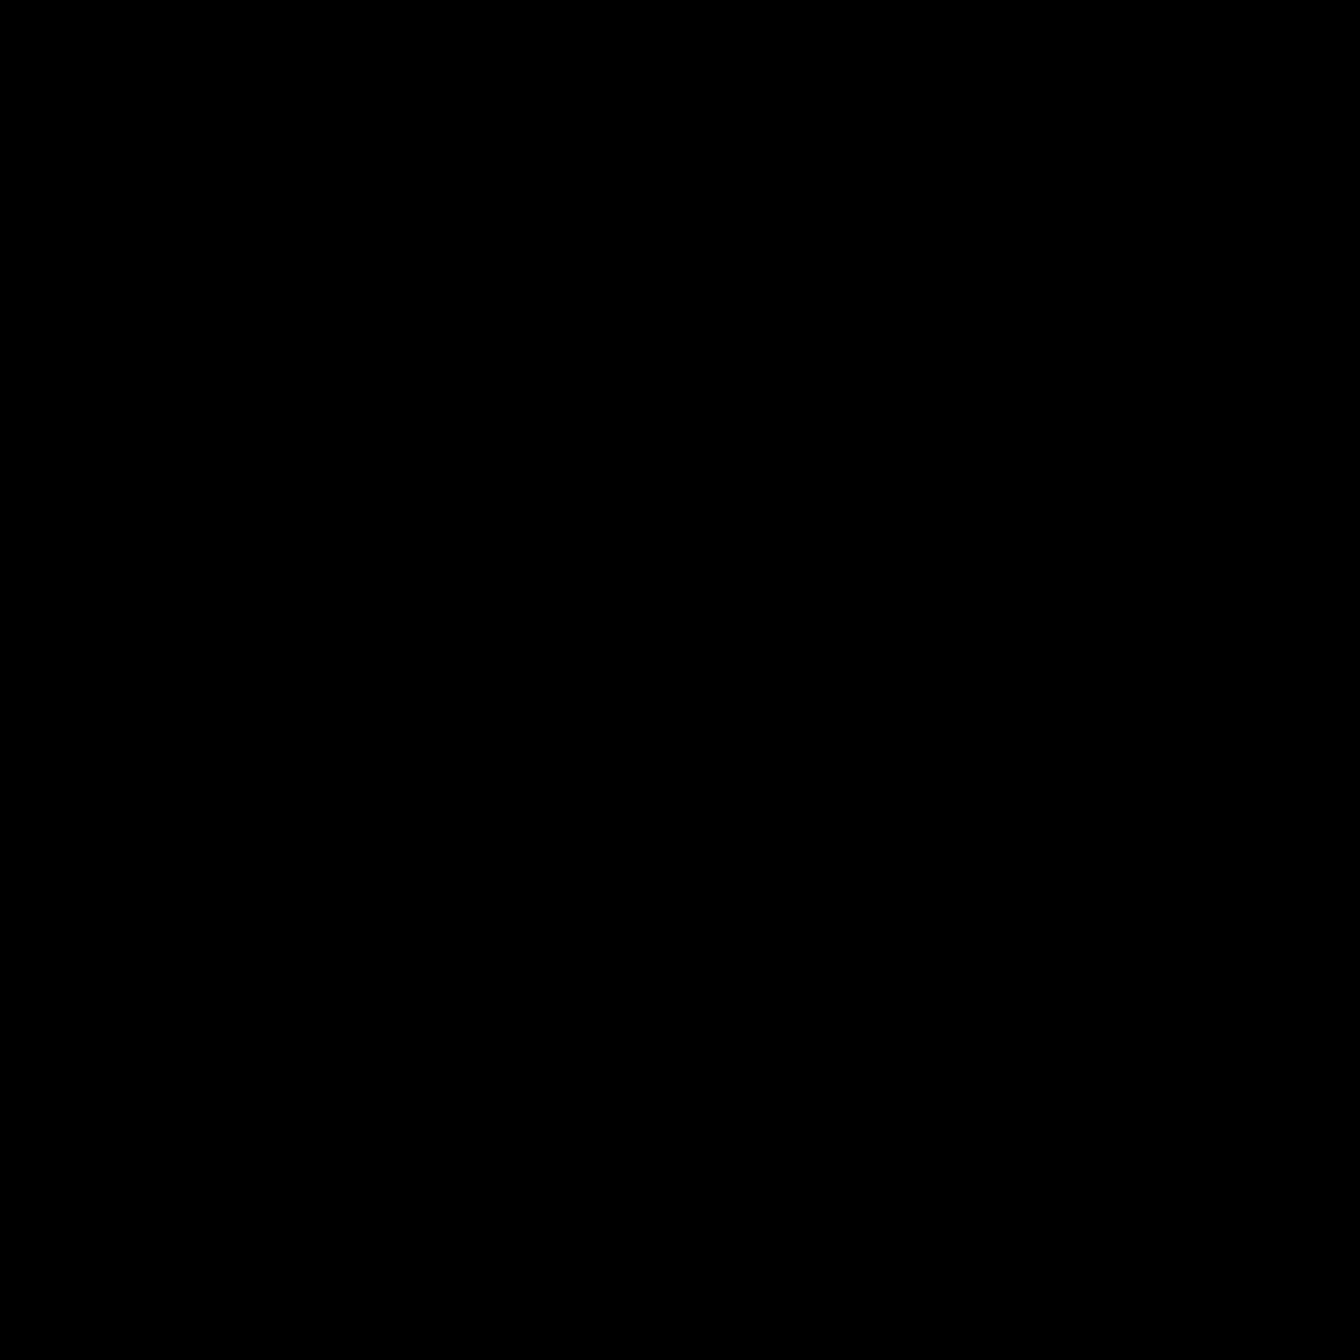

0


In [6]:
from skimage import measure
import alphashape
import numpy as np
import IPython
import random
import cv2 as cv2

def imshow(img,size=(500,500)):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret,width=size[0],height=size[1])
    IPython.display.display(i)



def extract_polygon_boundary(points, alpha=0.1):
    alpha_shape = alphashape.alphashape(points, alpha)
    boundary_points = np.array(alpha_shape.exterior.coords.xy).T
    return boundary_points

image = cv2.imread('SISTEMAS_UFF/Labels/cubemap_P74_0030931c0e3aaaa3a10a9e0f63195eb2_id_negx.png')[:,:,0]

image[image<255] += 1
image[image<255] *= 20

print(np.unique(image))
print(image.shape)
print(image.shape)


copied = np.copy(image)
regions = measure.regionprops(copied)
print(len(regions))

#imshow(image)
canvas_for_polygon = np.zeros_like(image)+255

for class_id in range(len(regions)):
    class_present = regions[class_id]
    canvas_for_mask = np.zeros_like(image)
    if class_present.label<255:

        print(f"class_label: {class_present.label}")
        bounding_boxes = class_present.bbox
        print(f"bounding_boxes: {bounding_boxes}")
        BB_index = np.s_[bounding_boxes[0]:bounding_boxes[2], bounding_boxes[1]:bounding_boxes[3]]
        
        canvas_for_mask[BB_index] = class_present.image

        print((class_present.image*255).shape)

        contours, hierarchy = cv2.findContours((canvas_for_mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        

        canvas_for_polygon = cv2.fillPoly(canvas_for_polygon, contours, class_present.label)

        
imshow((canvas_for_polygon-image)*255)
print((canvas_for_polygon-image).sum())

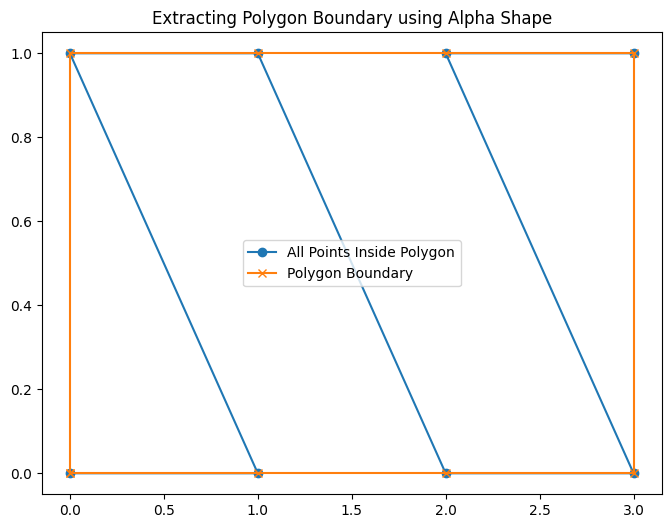

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import alphashape

def extract_polygon_boundary(points, alpha=0.1):
    alpha_shape = alphashape.alphashape(points, alpha)
    boundary_points = np.array(alpha_shape.exterior.coords.xy).T
    return boundary_points

# Example usage:
points_array = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
    [2, 0],
    [3, 0],
    [2, 1],
    [3, 1]
])

boundary_points = extract_polygon_boundary(points_array)

# Plot the original and extracted boundary
plt.figure(figsize=(8, 6))
plt.plot(points_array[:, 0], points_array[:, 1], label='All Points Inside Polygon', marker='o')
plt.plot(boundary_points[:, 0], boundary_points[:, 1], label='Polygon Boundary', marker='x')
plt.legend()
plt.title('Extracting Polygon Boundary using Alpha Shape')
plt.show()


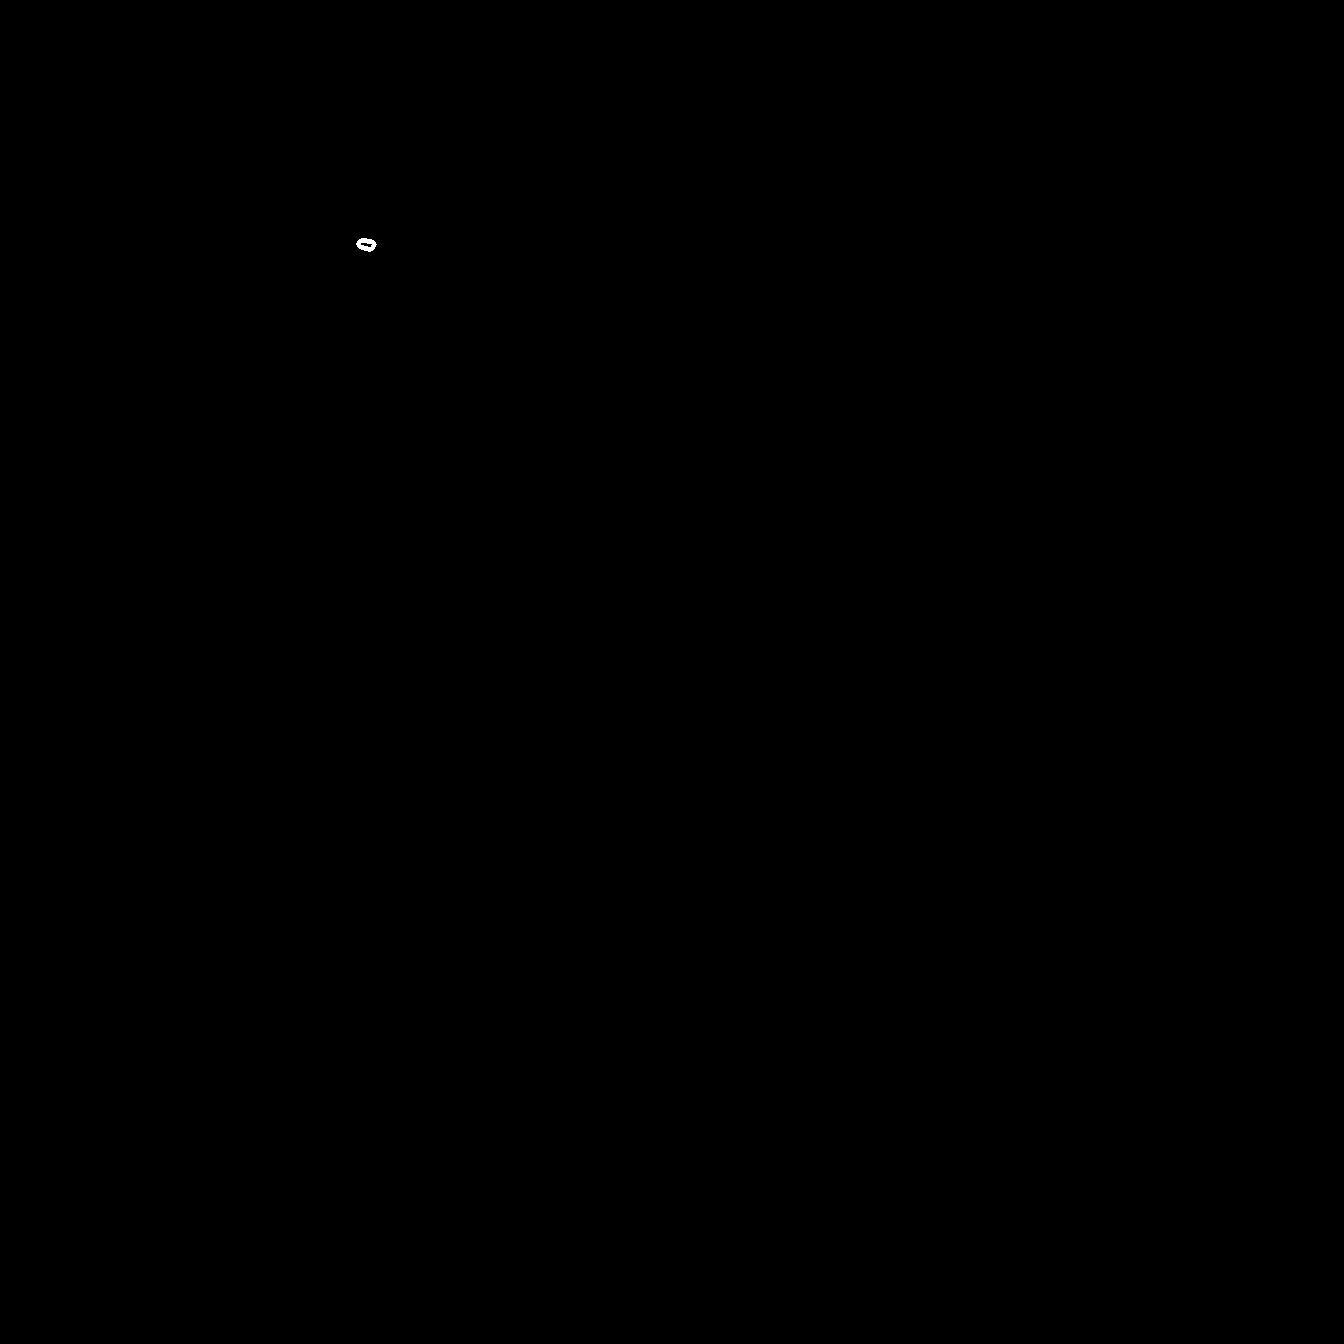

In [29]:
import numpy as np
import cv2 as cv2
im = canvas_used
im_clean = np.zeros_like(im)
assert im is not None, "file could not be read, check with os.path.exists()"
#imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

imshow(cv2.drawContours(im_clean, contours, -1, 255, 3))